In [1]:

%matplotlib widget            
# NB: must be *before* importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})
plt.ioff()                    # we'll display the figure manually as a widget

import sys, json, yaml, pickle, logging, numpy as np
import plotly.graph_objects as go
from ipywidgets import Dropdown, IntRangeSlider, FloatSlider, Label, VBox, HBox, Output, Button
from IPython.display import display

# ----------------------------------------------------------------------------- 
# 1.  Module-import PATHS (unchanged)
pkg_root = "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation"
sys.path.insert(0, pkg_root)

# --- Your pipeline’s imports (unchanged) -------------------------------------
from scint_analysis import config, pipeline, plotting
from scint_analysis.analysis import lorentzian_component, gaussian_component
from scint_analysis.core import ACF
from scint_analysis.config import update_fitting_parameter, update_pipeline_parameter, update_yaml_guesses

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# ----------------------------------------------------------------------------- 
# 2.  Load burst config & initialise pipeline (unchanged)
BURST_CONFIG_PATH = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/configs/bursts/freya_dsa.yaml'
ACF_RESULTS_PATH  = '/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl'

analysis_config = config.load_config(BURST_CONFIG_PATH)
print("--- Loaded Configuration ---")
print(json.dumps(analysis_config, indent=2))

print("\n--- Initialising Scintillation Pipeline ---")
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)
scint_pipeline.prepare_data()      # populates `masked_spectrum`

# ----------------------------------------------------------------------------- 
# 3.  Interactive window selector (Matplotlib + ipympl, flicker-free)
if scint_pipeline.masked_spectrum is None:
    print("Please run the initial pipeline-setup cells first.")
else:

    # Helper: persist slider choices back to YAML -----------------------------
    def _update_rfi_config(cfg_path, key, val):
        try:
            with open(cfg_path, 'r') as fh:
                data = yaml.safe_load(fh) or {}
            data.setdefault('analysis', {}).setdefault('rfi_masking', {})[key] = val
            with open(cfg_path, 'w') as fh:
                yaml.dump(data, fh, default_flow_style=False, sort_keys=False)
            return f"Success! Updated '{key}' → {val}."
        except Exception as exc:
            return f"YAML update failed: {exc}"

    # ------------------------------------------------------------------------
    def interactive_window_selector(pipeline_obj, cfg_path):

        # --- Data ------------------------------------------------------------
        spec         = pipeline_obj.masked_spectrum
        time_series  = spec.get_profile().filled(0)
        time_axis    = spec.times
        max_bin      = len(time_axis) - 1
        total_dur    = time_axis[-1] - time_axis[0]
        centre_t     = time_axis[np.argmax(time_series)]

        # --- Widgets ---------------------------------------------------------
        on_slider   = IntRangeSlider(value=[max_bin//2, 3*max_bin//4], min=0, max=max_bin,
                                     step=1, description='On-pulse bins:', layout={'width':'95%'})
        off_slider  = IntRangeSlider(value=[0, max_bin//4],              min=0, max=max_bin,
                                     step=1, description='Off-pulse bins:', layout={'width':'95%'})
        zoom_slider = FloatSlider(value=total_dur, min=0.01*total_dur, max=total_dur,
                                  step=total_dur/200, description='Zoom width (s):',
                                  readout_format='.3f', layout={'width':'95%'})
        save_btn    = Button(description="Save windows to YAML", button_style='primary', icon='save')
        status_lbl  = Label("Adjust sliders to select regions.")
        plot_box    = Output()   # container for the ipympl figure

        # --- Build figure *once* --------------------------------------------
        with plot_box:
            fig, ax = plt.subplots(figsize=(12, 5))
            fig.canvas.header_visible = False
            display(fig.canvas)  
            (ln,)   = ax.plot(time_axis, time_series, color='navy', label='Profile')
            # initial spans
            on_span  = ax.axvspan(time_axis[on_slider.value[0]],
                                  time_axis[on_slider.value[1]],
                                  0, 1,
                                  color='cyan', alpha=0.4, label='On-pulse')
            off_span = ax.axvspan(time_axis[off_slider.value[0]],
                                  time_axis[off_slider.value[1]],
                                  0, 1,
                                  color='orange', alpha=0.4, label='Off-pulse (noise)')
            ax.set_xlabel("Time (s)");  ax.set_ylabel("Power")
            ax.set_title("On/Off-pulse Window Selector")
            ax.grid(True, linestyle=':'); ax.legend()
            ax.set_xlim(centre_t - zoom_slider.value/2, centre_t + zoom_slider.value/2)
            # NB: fig is a widget; no need for plt.show()

        # --- Artist-update ---------------------------------------------------ue/2)
        def _update(_=None):
            on_x0, on_x1   = time_axis[on_slider.value[0]],  time_axis[on_slider.value[1]]
            off_x0, off_x1 = time_axis[off_slider.value[0]], time_axis[off_slider.value[1]]

            on_span.set_x(on_x0)                 # move left edge
            on_span.set_width(on_x1 - on_x0)     # stretch/shrink

            off_span.set_x(off_x0)
            off_span.set_width(off_x1 - off_x0)

            ax.set_xlim(centre_t - zoom_slider.value/2,
                        centre_t + zoom_slider.value/2)
            fig.canvas.draw_idle()

        # --- YAML-save callback ---------------------------------------------
        def _save(_):
            on_win  = list(on_slider.value)
            off_win = list(off_slider.value)
            m1 = _update_rfi_config(cfg_path, 'manual_burst_window', on_win)
            m2 = _update_rfi_config(cfg_path, 'manual_noise_window', off_win)
            status_lbl.value = f"{m1}  |  {m2}"
            pipeline_obj.config['analysis']['rfi_masking']['manual_burst_window'] = on_win
            pipeline_obj.config['analysis']['rfi_masking']['manual_noise_window']  = off_win

        # --- Wiring ----------------------------------------------------------
        for w in (on_slider, off_slider, zoom_slider):
            w.observe(_update, names='value')
        save_btn.on_click(_save)

        # Initial draw and layout -------------------------------------------
        _update()   # draw once with initial slider positions
        display(VBox([zoom_slider, on_slider, off_slider,
                      plot_box,
                      HBox([save_btn, status_lbl])]))

    # Run the tool -----------------------------------------------------------
    interactive_window_selector(scint_pipeline, BURST_CONFIG_PATH)


KeyboardInterrupt: 

INFO: Data already prepared. Skipping.
INFO: --- Starting Scintillation Pipeline for freya ---
INFO: Applying polynomial baseline subtraction...
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 23)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_on_pulse_diagnostic.png


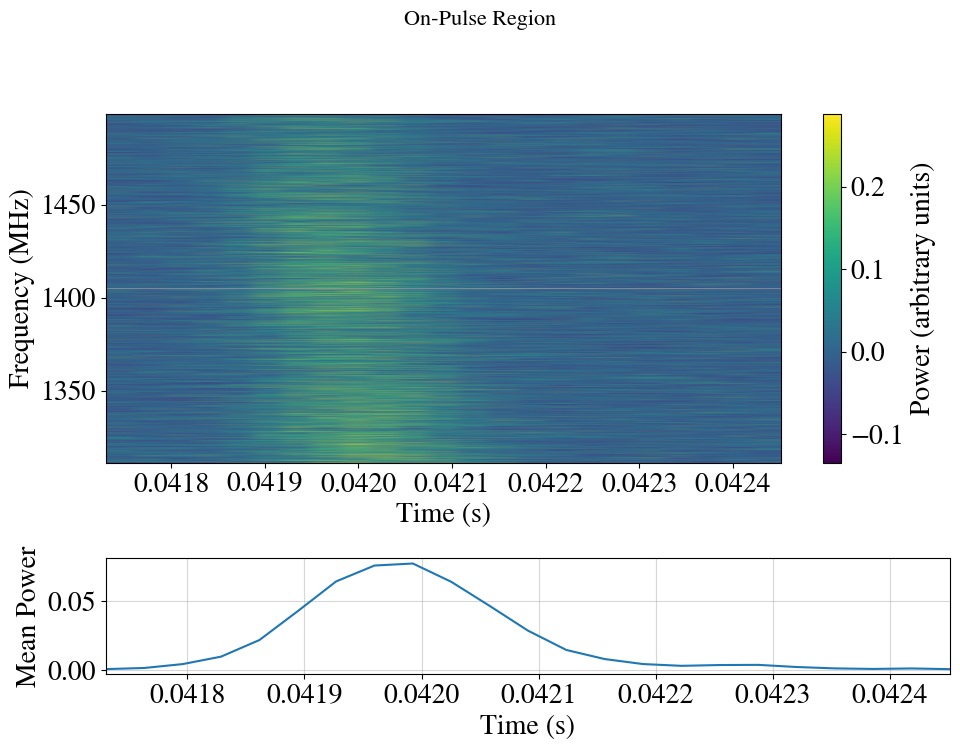

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1214)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_off_pulse_diagnostic.png


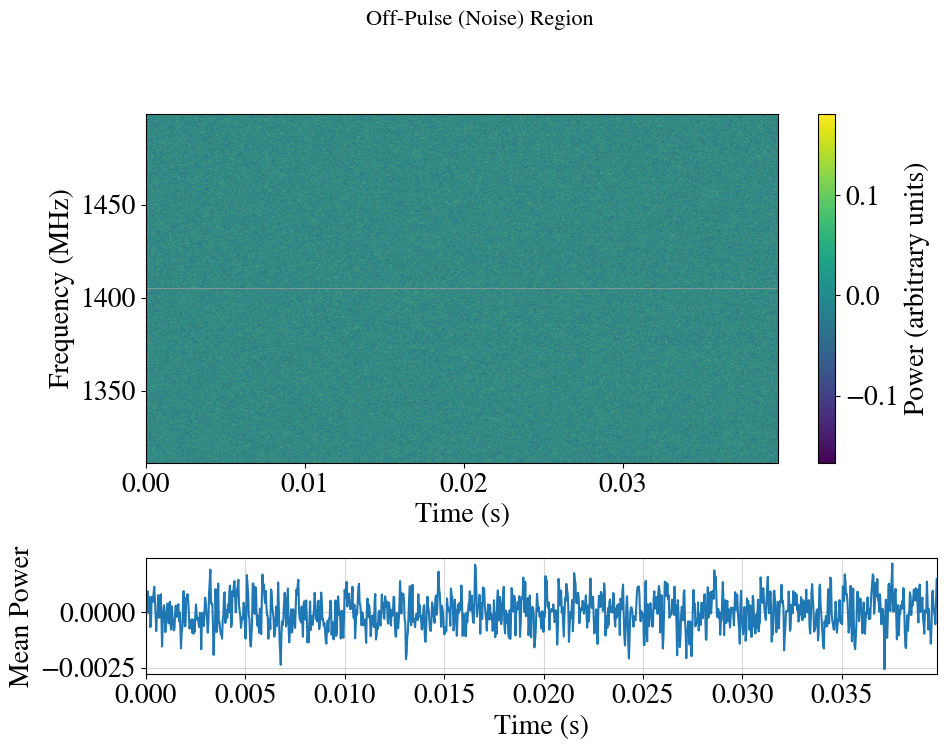

INFO: On/Off pulse diagnostic plots saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/plots/diagnostics/freya_baseline_diagnostic.png


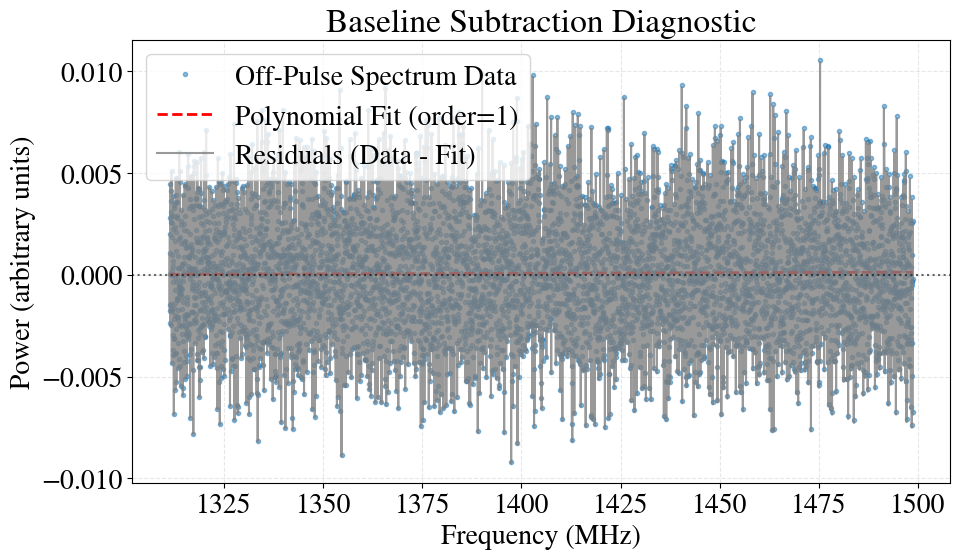

INFO: Characterizing off-pulse noise...
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 4/4 [00:46<00:00, 11.60s/it]
INFO: Saved ACF results to cache: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/chime_dsa_codetections/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl
INFO: 'halt_after_acf' is set to True. Halting pipeline as requested.


--- Pipeline Execution Finished ---


In [ ]:
plt.close('all')
%matplotlib inline

# --- 4. Run the Pipeline ---
# This single .run() call executes all the steps in the correct order:
# - Loads and masks data
# - Characterizes off-pulse noise (NEW)
# - Calculates ACFs using the noise model for normalization
scint_pipeline.run()
print("--- Pipeline Execution Finished ---")

In [ ]:
# ==============================================================================
# Manual ACF Fitting Notebook – hierarchical 1–3-component fitter  ✨
# ------------------------------------------------------------------
# Now using ipympl for smooth, flicker-free interactivity.
# ------------------------------------------------------------------------------
# • Choose up to THREE single-component models (Lorentzian, Gaussian,
#   Generalised-Lorentzian, Power-law) and build a composite fit on-the-fly.
# • Hard lower limit on all γ / σ sliders and bounds: 0.1.
# • Live initial-guess preview, lag-range sync, stored-fits printer, YAML export.
# ==============================================================================

# ── Backend & style ───────────────────────────────────────────────────────────
# If ipympl isn't installed, run once:
# %pip install -q ipympl
%matplotlib widget

import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["STIXGeneral", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "font.size": 20,
    "axes.unicode_minus": True,
})
plt.ioff()                           # we'll display the canvas manually

# ── Std. libs & widgets ──────────────────────────────────────────────────────
import pickle, yaml, numpy as np, logging
from lmfit import Model
from lmfit.models import ConstantModel
from ipywidgets import (
    IntSlider, FloatSlider, FloatRangeSlider, FloatText,
    Dropdown, Checkbox, VBox, HBox, Button, Output, Textarea, Label
)
from IPython.display import display

# ── Project-specific imports (unchanged) ─────────────────────────────────────
from scint_analysis.analysis import (
    _make_noise_model,
    calculate_acf,
    lorentzian_component,
    gaussian_component,
    lorentzian_generalised,
    power_law_model,
)

# ──────────────────────────────────────────────────────────────────────────────
# 1.  Load cached ACF data
# ──────────────────────────────────────────────────────────────────────────────
with open(ACF_RESULTS_PATH, "rb") as f:
    acf_results = pickle.load(f)

num_subbands = len(acf_results["subband_acfs"])
print(f"Loaded ACFs for {num_subbands} sub-bands.")

# ──────────────────────────────────────────────────────────────────────────────
# 2.  Library of single-component models (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
MODEL_CONFIG = {
    "Lorentzian":  dict(func=lorentzian_component,     prefix="l_",  param_names=["gamma", "m"]),
    "Gaussian":    dict(func=gaussian_component,       prefix="g_",  param_names=["sigma", "m"]),
    "Gen-Lorentz": dict(func=lorentzian_generalised,   prefix="lg_", param_names=["gamma", "alpha", "m"]),
    "Power-Law":   dict(func=power_law_model,          prefix="p_",  param_names=["c", "n"]),
}

# ──────────────────────────────────────────────────────────────────────────────
# 3.  Widgets (unchanged except layout tweaks)
# ──────────────────────────────────────────────────────────────────────────────
subband_slider = IntSlider(0, 0, num_subbands - 1, 1, description="Sub-band:")

prim_dd  = Dropdown(options=list(MODEL_CONFIG.keys()), value="Lorentzian", description="Model 1:")
add2_cb  = Checkbox(False, description="+2nd")
sec_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Gaussian",   description="Model 2:", disabled=True)
add3_cb  = Checkbox(False, description="+3rd")
thr_dd   = Dropdown(options=list(MODEL_CONFIG.keys()), value="Power-Law",  description="Model 3:", disabled=True)

add2_cb.observe(lambda ch: setattr(sec_dd, "disabled", not ch["new"]), names="value")
add3_cb.observe(lambda ch: setattr(thr_dd, "disabled", not ch["new"]), names="value")

max_lag = float(max(np.max(np.abs(l)) for l in acf_results["subband_lags_mhz"]))
fit_min_txt   = FloatText(-max_lag, description="Min Lag:")
fit_max_txt   = FloatText( max_lag, description="Max Lag:")
fit_rng_slider = FloatRangeSlider(value=(-max_lag, max_lag), min=-max_lag, max=max_lag,
                                  step=0.1, description="Fit Range Slider:")

ignore_err_cb = Checkbox(False, description="Ignore σ")

fit_btn   = Button(description="Perform Fit", button_style="success", icon="cogs")
print_btn = Button(description="Print Fits",  button_style="info",    icon="print")
save_btn  = Button(description="Save→YAML",   button_style="warning", icon="save")
plot_noise_btn = Button(description="Plot Noise Synthesis", button_style="info", icon="chart-area")

param_box  = VBox([])
plot_out   = Output()
results_tb = Textarea(layout={"width": "98%", "height": "200px"})
status_lbl = Label()
stats_lbl  = Label("Fit Stats: N/A")

# ──────────────────────────────────────────────────────────────────────────────
# 4.  Parameter-widget factory (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
LOWER_WIDTH = 0.06  # hard floor for gamma / sigma

def _slider(desc, kind, val=0.5):
    if kind == "width":
        return FloatSlider(value=max(val, LOWER_WIDTH), min=LOWER_WIDTH, max=15,
                           step=0.01, description=desc)
    if kind == "m":
        return FloatSlider(value=val, min=0, max=4, step=0.01, description=desc)
    if kind == "c":
        return FloatSlider(value=0.0, min=0., max=0.5, step=0.001, description=desc)
    if kind == "alpha":
        return FloatText(value=5/3, description=desc)
    if kind == "n":
        return FloatSlider(value=-2, min=-6, max=-1, step=0.1, description=desc)
    return FloatText(value=val, description=desc)

def _make_widgets(model_key: str, idx: int):
    cfg, prefix = MODEL_CONFIG[model_key], MODEL_CONFIG[model_key]['prefix']
    names, widgets, i = cfg["param_names"], [], 0
    while i < len(names):
        nm = names[i]
        if nm.startswith(("gamma", "sigma")):
            w_width = _slider(f"{prefix}{idx}_{nm}", "width")
            w_width.observe(_on_visual_change, names="value")
            row = [w_width]
            if i + 1 < len(names) and names[i + 1].startswith("m"):
                w_m = _slider(f"{prefix}{idx}_{names[i+1]}", "m")
                w_m.observe(_on_visual_change, names="value")
                row.append(w_m)
                i += 1
            widgets.append(HBox(row))
        elif nm == "alpha":
            w_alpha = _slider(f"{prefix}{idx}_{nm}", "alpha")
            w_alpha.observe(_on_visual_change, names="value")
            widgets.append(w_alpha)
        elif nm.startswith("m"):
            w_m = _slider(f"{prefix}{idx}_{nm}", "m")
            w_m.observe(_on_visual_change, names="value")
            widgets.append(w_m)
        elif nm == "c":
            w_c = _slider(f"{prefix}{idx}_{nm}", "c")
            w_c.observe(_on_visual_change, names="value")
            widgets.append(w_c)
        elif nm == "n":
            w_n = _slider(f"{prefix}{idx}_{nm}", "n")
            w_n.observe(_on_visual_change, names="value")
            widgets.append(w_n)
        i += 1
    return widgets

def _refresh_param_box(*_):
    children = _make_widgets(prim_dd.value, 1)
    if add2_cb.value:
        children += _make_widgets(sec_dd.value, 2)
    if add3_cb.value:
        children += _make_widgets(thr_dd.value, 3)
    param_box.children = tuple(children)
    _draw_plot(initial_only=True)

for w in (prim_dd, sec_dd, thr_dd, add2_cb, add3_cb):
    w.observe(_refresh_param_box, names="value")

# ──────────────────────────────────────────────────────────────────────────────
# 5.  Helpers (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
def _param_vals():
    vals = []
    for child in param_box.children:
        vals += [wid.value for wid in (child.children if isinstance(child, HBox) else (child,))]
    return vals

def _auto_bounds(params):
    for name, par in params.items():
        if any(k in name for k in ("gamma", "sigma")):
            par.set(min=LOWER_WIDTH)
        elif name.endswith("m") or name.endswith("_m"):
            par.set(min=0)
        elif "alpha" in name:
            par.set(min=0.1, max=6)

# ──────────────────────────────────────────────────────────────────────────────
# 6.  Plot area – create once, then update in-place
# ──────────────────────────────────────────────────────────────────────────────
with plot_out:
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.canvas.header_visible = False
    display(fig.canvas)           # show the live canvas

def _draw_plot(initial_only=False, fit_res=None):
    """Refresh the live figure; avoids flicker by re-using the same canvas."""
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None]*num_subbands)[sb]

    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x_fit, y_fit = lags[mask], acf[mask]

    ax.clear()                                         # keep canvas, clear axes
    ax.errorbar(lags, acf,
                yerr=None if (errs is None or ignore_err_cb.value) else errs,
                fmt=".", ms=3, capsize=3, color="lightgray", label="All data", zorder=1)
    ax.plot(x_fit, y_fit, '-', color="purple", alpha=0.6, label="Fit range", zorder=2)

    if initial_only and x_fit.size:
        vals, idx, guess = _param_vals(), 0, np.zeros_like(x_fit)
        sequence = [prim_dd.value] \
                 + ([sec_dd.value]  if add2_cb.value else []) \
                 + ([thr_dd.value]  if add3_cb.value else [])
        for key in sequence:
            cfg, npar = MODEL_CONFIG[key], len(MODEL_CONFIG[key]["param_names"])
            guess += cfg["func"](x_fit, *vals[idx: idx+npar])
            idx += npar
        ax.plot(x_fit, guess, color="pink", label="Initial guess")

    if fit_res is not None:
        ax.plot(x_fit, fit_res.best_fit, "k-", lw=2.5, label="Best Composite Fit")
        for prefix, comp in fit_res.eval_components(x=x_fit).items():
            if 'tpl' in prefix:
                ax.plot(x_fit, comp, 'm--', lw=2, label='Noise Template Fit')

    ax.set_ylim(np.min(y_fit)-0.05, np.max(y_fit)+0.05)
    ax.set_xlim(m0 - 0.05*(m1-m0), m1 + 0.05*(m1-m0))
    ax.set_xlabel("Δν (MHz)")
    ax.set_ylabel("C_I")
    ax.grid(ls=":")
    ax.legend(loc="upper right")
    fig.canvas.draw_idle()                             # lightweight repaint

def _on_visual_change(_=None):
    _draw_plot(initial_only=True)

# ──────────────────────────────────────────────────────────────────────────────
# 7.  Lag-range textbox ⇆ slider sync (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
def _sync_text_to_slider(_):
    if fit_min_txt.value < fit_max_txt.value:
        fit_rng_slider.value = (fit_min_txt.value, fit_max_txt.value)

def _sync_slider_to_text(ch):
    fit_min_txt.value, fit_max_txt.value = (round(ch["new"][0], 2),
                                            round(ch["new"][1], 2))

fit_min_txt.observe(_sync_text_to_slider, names="value")
fit_max_txt.observe(_sync_text_to_slider, names="value")
fit_rng_slider.observe(_sync_slider_to_text, names="value")
fit_rng_slider.observe(_on_visual_change, names="value")
fit_min_txt.observe(_on_visual_change, names="value")
fit_max_txt.observe(_on_visual_change, names="value")
subband_slider.observe(_on_visual_change, names="value")

# ──────────────────────────────────────────────────────────────────────────────
# 8.  Fit callback (unchanged logic)
# ──────────────────────────────────────────────────────────────────────────────
all_fits = {}

def _on_fit(_):
    sb = subband_slider.value
    lags = acf_results["subband_lags_mhz"][sb]
    acf  = acf_results["subband_acfs"][sb]
    errs = acf_results.get("subband_acfs_err", [None]*num_subbands)[sb]
    m0, m1 = fit_rng_slider.value
    mask = (lags >= m0) & (lags <= m1) & (lags != 0)
    x, y = lags[mask], acf[mask]
    wts = None if (ignore_err_cb.value or errs is None) else 1.0/np.maximum(errs[mask], 1e-9)
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])

    signal_model, params, vals, idx = None, None, _param_vals(), 0
    for i, key in enumerate(comps, start=1):
        cfg = MODEL_CONFIG[key]
        m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
        p = m.make_params()
        n = len(cfg["param_names"])
        for val, pname in zip(vals[idx: idx+n], p.keys()):
            p[pname].set(value=val)
        idx += n
        _auto_bounds(p)
        signal_model, params = (m, p) if signal_model is None else (signal_model + m, params.update(p) or signal_model)

    const_model = ConstantModel(prefix='c_')
    params = (params or const_model.make_params()).copy()
    params.update(const_model.make_params(c=0.0))
    composite_model = (signal_model + const_model) if signal_model is not None else const_model

    result = composite_model.fit(y, params, x=x, weights=wts)
    all_fits[(sb, tuple(comps))] = result

    mean_sigma = np.nan if wts is None else float(1/np.mean(wts))
    stats_lbl.value = f"χ²ᵣ = {result.redchi:.3f}   |   BIC = {result.bic:.2f}   |   ⟨σ⟩ = {mean_sigma:.4f}"
    _draw_plot(fit_res=result)

# ──────────────────────────────────────────────────────────────────────────────
# 9.  Print / YAML / noise-plot callbacks (unchanged)
# ──────────────────────────────────────────────────────────────────────────────
def _on_print(_):
    out = []
    for (sb, comps), res in all_fits.items():
        cf = acf_results["subband_center_freqs_mhz"][sb]
        out.append(f"--- Sub-band {sb} @ {cf:.2f} MHz :: {' + '.join(comps)}")
        for n, p in res.params.items():
            serr = p.stderr if p.stderr is not None else 0
            out.append(f"  {n}: {p.value:.4g} ± {serr:.2g}")
        out.append("")
    results_tb.value = "\n".join(out) if out else "No fits yet."

def _on_save(_):
    sb = subband_slider.value
    comps = [prim_dd.value] + ([sec_dd.value] if add2_cb.value else []) + ([thr_dd.value] if add3_cb.value else [])
    key  = (sb, tuple(comps))
    if key not in all_fits:
        status_lbl.value = "Run a fit first."
        return
    res, tag = all_fits[key], "+".join(comps)
    fit_range_mhz = list(fit_rng_slider.value)
    params_to_save = {n: {"value": float(p.value), "stderr": float(p.stderr or 0.)}
                      for n, p in res.params.items()}

    entry = dict(
        reference_frequency_mhz=float(acf_results["subband_center_freqs_mhz"][sb]),
        best_fit_params=params_to_save,
        redchi=float(res.redchi),
        bic=float(res.bic),
        fit_range_mhz=fit_range_mhz,
    )

    cfg = yaml.safe_load(open(BURST_CONFIG_PATH)) or {}
    cfg.setdefault("analysis", {}).setdefault("stored_fits", {}).setdefault(f"subband_{sb}", {})[tag] = entry
    yaml.safe_dump(cfg, open(BURST_CONFIG_PATH, "w"), sort_keys=False)
    status_lbl.value = f"Saved under subband_{sb} :: {tag}"

def _on_plot_noise_clicked(_):
    plot_noise_template_synthesis(subband_slider.value)

# ──────────────────────────────────────────────────────────────────────────────
# 10.  Wire callbacks & build dashboard
# ──────────────────────────────────────────────────────────────────────────────
fit_btn.on_click(_on_fit)
print_btn.on_click(_on_print)
save_btn.on_click(_on_save)
plot_noise_btn.on_click(_on_plot_noise_clicked)

fit_range_box = VBox([
    Label("Fit Lag Range (MHz):"),
    HBox([fit_min_txt, fit_max_txt]),
    fit_rng_slider,
])

dashboard = VBox([
    HBox([subband_slider, prim_dd, add2_cb, sec_dd, add3_cb, thr_dd]),
    fit_range_box,
    Label(r"Component Parameters $\gamma$, $\sigma$, $m$, $\alpha$, $n$"),
    param_box,
    HBox([fit_btn, print_btn, save_btn, plot_noise_btn]),
    status_lbl,
    stats_lbl,
    plot_out,
    results_tb,
])

display(dashboard)
_refresh_param_box()              # populate sliders & initial preview


Loaded ACFs for 4 sub-bands.


In [23]:
# In scint_analysis/plotting.py

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plt.close('all')
%matplotlib inline

# In Cell 3 of your notebook, update this function

def format_value_with_error(value, error):
    """
    Formats a value and its error into the compact X(err) notation.
    e.g., 17.3 ± 1.5 becomes "17.3(15)"
    e.g., 0.3346 ± 0.0429 becomes "0.335(43)"
    """
    if error is None or not np.isfinite(error) or error <= 0:
        return f"{value:.3f}"

    # Determine the number of decimal places to round to, based on the error's magnitude
    # We aim for two significant figures in the error
    decimals = -int(np.floor(np.log10(error))) + 1
    decimals = max(0, decimals)
    
    # Format the value with the determined number of decimals
    value_str = f"{value:.{decimals}f}"
    
    # Format the error as an integer of the last digits
    error_int = int(round(error * (10**decimals)))
    
    return f"{value_str}({error_int})"

def load_fit_from_yaml(config_path, subband_index, model_name, lags):
    """
    Loads a saved fit from the YAML config, rebuilds the model, 
    and returns the evaluated curves and parameters for plotting.
    """
    with open(config_path, 'r') as f:
        config_data = yaml.safe_load(f)

    try:
        fit_data = config_data['analysis']['stored_fits'][f'subband_{subband_index}'][model_name]
        saved_params = fit_data['best_fit_params']
        redchi = fit_data['redchi']
        # --- NEW: Get the saved fit range ---
        fit_range = fit_data.get('fit_range_mhz') # .get() is safer
    except KeyError:
        print(f"Error: Could not find saved fit for sub-band {subband_index} with model '{model_name}'")
        return None

    # Rebuild the lmfit model (this logic is unchanged)
    component_keys = model_name.split('+')
    signal_model, params = None, None
    for i, key in enumerate(component_keys, start=1):
        if key in MODEL_CONFIG:
            cfg = MODEL_CONFIG[key]
            m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
            if signal_model is None:
                signal_model = m
            else:
                signal_model += m
    
    const_model = ConstantModel(prefix='c_')
    composite_model = signal_model + const_model
    params = composite_model.make_params()

    # Set the parameter values from the loaded dictionary
    for param_name, param_info in saved_params.items():
        if param_name in params:
            # Get just the 'value' from the sub-dictionary
            params[param_name].set(value=param_info['value']) 

    # Evaluate curves
    best_fit_curve = composite_model.eval(params=params, x=lags)
    component_curves = composite_model.eval_components(params=params, x=lags)
    
    # --- NEW: Return the parameters dictionary as well ---
    return {
        "best_fit_curve": best_fit_curve,
        "component_curves": component_curves,
        "redchi": redchi,
        "params": saved_params,
        "fit_range_mhz": fit_range
    }

# In scint_analysis/plotting.py

def plot_publication_acf(
    acf_obj: ACF,
    best_fit_curve: np.ndarray,
    component_curves: dict,
    redchi: float,
    params: dict,
    fit_range_mhz: list,
    zoom_lag_range_mhz=(-20, 20),
    save_path=None
):
    """
    Generates a publication-quality, 3-panel plot from pre-evaluated fit curves.
    """
    # Calculate residuals from the provided best_fit_curve argument
    plot_mask = (acf_obj.lags != 0)
    # Take the sqrt of all y-data, clipping at 0 to avoid sqrt(negative).
    m_data = np.sqrt(np.maximum(0, acf_obj.acf))
    m_fit_curve = np.sqrt(np.maximum(0, best_fit_curve))
    m_component_curves = {key: np.sqrt(np.maximum(0, curve)) for key, curve in component_curves.items()}
    
    # Propagate the errors: sigma_m = sigma_m^2 / (2*m)
    m_err = None
    if acf_obj.err is not None:
        # Avoid division by zero for points where m_data is zero
        m_err = np.divide(acf_obj.err, 2 * m_data, out=np.zeros_like(m_data), where=(m_data != 0))

    # Calculate residuals in the new space
    residuals = m_data - m_fit_curve
    #residuals = acf_obj.acf - best_fit_curve
    full_lag_range_mhz=(acf_obj.lags.min(), acf_obj.lags.max())

    # Auto-generate a descriptive legend label for the composite fit
    shape_component_keys = sorted([k for k in component_curves if 'c_' not in k])
    label_parts = []
    # Map model prefixes to their mathematical symbols
    model_map = {'l_': 'L', 'g_': 'G', 'lg_': 'L_{gen}', 'p_': 'P'}

    for prefix in shape_component_keys:
        # e.g., prefix is 'l_1_'
        base_prefix = prefix.split('_')[0] + '_'  # e.g., 'l_'
        index = prefix.split('_')[1]              # e.g., '1'
        symbol = model_map.get(base_prefix, '?')  # e.g., 'L'
        label_parts.append(f"$\mathcal{{{symbol}}}_{{{index}}}$")

    if 'c_' in component_curves:
        label_parts.append("$c$")

    composite_label = "Fit: " + " + ".join(label_parts)

    fig, (ax_a, ax_b, ax_c) = plt.subplots(
        3, 1,
        figsize=(10, 8),
        sharex=False,
        gridspec_kw={'height_ratios': [2, 3, 1.5]},
        constrained_layout=True
    )
    
    #cmap = cm.get_cmap('plasma', 4)
    colors = plt.get_cmap('plasma')(np.linspace(0.25, 0.75, 6))

    # --- Panel a: Wide View ---
    if acf_obj.err is not None:
        ax_a.errorbar(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], yerr=acf_obj.err[plot_mask], fmt='none', capsize=2, ecolor='lightgrey', alpha=1)
    ax_a.plot(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], color=colors[0], alpha=0.6, lw=1)
    ax_a.plot(acf_obj.lags, best_fit_curve, 'k-', lw=1.5, label=composite_label)
    ax_a.axvspan(zoom_lag_range_mhz[0], zoom_lag_range_mhz[1], color=colors[1], alpha=0.3, hatch='//', zorder=-1, label='Zoom In ($\mathbf{b}$)')
    #ax_a.set_xlim(full_lag_range_mhz)
    ax_a.set_xlim(acf_obj.lags.min(), acf_obj.lags.max())
    ax_a.set_ylim(np.min(acf_obj.acf[plot_mask])/2, np.max(acf_obj.acf[plot_mask])/2)
    ax_a.set_ylabel("ACF$~$ ($m^{2}$)")
    #ax_a.set_ylabel("Modulation Index (m)")
    #ax_a.grid(True, linestyle=':', alpha=0.6)
    ax_a.legend(loc = 'upper right',frameon=True,          # draw the legend patch
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')
    ax_a.text(0.02, 0.9, "a", transform=ax_a.transAxes, fontsize=20, fontweight='bold', va='top')

    # Set ylim for Panel A
    mask_a_zoom = (acf_obj.lags >= full_lag_range_mhz[0]) & (acf_obj.lags <= full_lag_range_mhz[1])
    if np.any(mask_a_zoom):
        min_val_a = np.min(acf_obj.acf[mask_a_zoom])/2
        max_val_a = np.max(acf_obj.acf[mask_a_zoom])/2
        padding_a = (max_val_a - min_val_a) * 0.1
        ax_a.set_ylim(min_val_a - padding_a, max_val_a + padding_a)

    # --- Panel b: Zoomed-in View ---
    if acf_obj.err is not None:
        ax_b.errorbar(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], yerr=acf_obj.err[plot_mask], fmt='none', capsize=2, ecolor='lightgrey', alpha=1)
    ax_b.plot(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], color=colors[2], alpha=0.6, lw=1)
    ax_b.plot(acf_obj.lags, best_fit_curve, 'k-', lw=2, label=composite_label)

    shape_component_keys = sorted([k for k in component_curves if 'c_' not in k])

    print("--- Fitted Decorrelation Bandwidths ---")
    for i, prefix in enumerate(shape_component_keys):
        color = colors[i]
        
        width_param_name = None
        for pname in params:
            if pname.startswith(prefix) and ('gamma' in pname or 'sigma' in pname):
                width_param_name = pname
                break
        
        if width_param_name and width_param_name in params:
            param_info = params[width_param_name]
            gamma_val, gamma_err = param_info['value'], param_info['stderr']

            gamma_val_khz = gamma_val * 1000
            gamma_err_khz = gamma_err * 1000 if gamma_err is not None else 0.0
            label_text = f"$\gamma_{i+1}$ = {format_value_with_error(gamma_val_khz, gamma_err_khz)} kHz"
            ax_b.plot(acf_obj.lags, m_component_curves[prefix], color=color, lw=2.0, linestyle='--', label=label_text)
            #ax_b.plot(acf_obj.lags, component_curves[prefix], color=color, lw=2.0, linestyle='--', label=label_text)
    
    ax_b.axvspan(fit_range_mhz[0], fit_range_mhz[1], color=colors[3], alpha=0.3, hatch='//', zorder=-1, label='$\chi^2_r$ Fit Range')
    ax_b.set_xlim(fit_range_mhz[0]-5, fit_range_mhz[1]+5)
    ax_b.set_ylabel("ACF$~$ ($m^{2}$)")
    ax_b.legend(loc='upper right', frameon=True,          # draw the legend patch
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')
    #ax_b.grid(True, linestyle=':', alpha=0.6)
    ax_b.text(0.02, 0.95, "b", transform=ax_b.transAxes, fontsize=20, fontweight='bold', va='top')

    # Create a mask for the data within the specified lag range
    # Create a mask for the data within the zoom range, using the FULL lags array
    mask_b_zoom = (acf_obj.lags >= zoom_lag_range_mhz[0]) & (acf_obj.lags <= zoom_lag_range_mhz[1])
    if np.any(mask_b_zoom):
        # Apply the combined mask to get the min/max
        min_val = np.min(acf_obj.acf[mask_b_zoom & plot_mask])
        max_val = np.max(acf_obj.acf[mask_b_zoom & plot_mask])
        padding = (max_val - min_val) * 0.1
        ax_b.set_ylim(min_val - padding, max_val + padding)

    # --- Panel c: Residuals ---
    #ax_c.plot(acf_obj.lags[plot_mask], residuals[plot_mask], color=colors[4], alpha=0.8, lw=1)
    ax_c.plot(acf_obj.lags[plot_mask], residuals[plot_mask], color=colors[4], alpha=0.8, lw=1)
    ax_c.axhline(0, color='k', linestyle='--', lw=1)
    ax_c.set_xlim(zoom_lag_range_mhz)
    
    # Create a mask for the data within the zoom range, using the FULL lags array
    mask_c_zoom = (acf_obj.lags >= zoom_lag_range_mhz[0]) & (acf_obj.lags <= zoom_lag_range_mhz[1])
    if np.any(mask_c_zoom):
        # Apply the combined mask to get the max absolute residual
        max_abs_resid = np.max(np.abs(residuals[mask_c_zoom & plot_mask]))
        ax_c.set_ylim(-max_abs_resid * 1.2, max_abs_resid * 1.2)
    
    ax_c.text(0.825, 0.9, f"$\chi_r^2$= {redchi:.2f}", transform=ax_c.transAxes,
              ha='left', va='top', bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'))
    
    ax_c.set_xlabel("Frequency lag (MHz)")
    ax_c.set_ylabel("Residuals")
    #ax_c.grid(True, linestyle=':', alpha=0.6)
    ax_c.text(0.02, 0.95, "c", transform=ax_c.transAxes, fontsize=20, fontweight='bold', va='top')

    plt.suptitle(r"$\nu_{c}$ = 1.4 GHz", fontsize=20, y=1.05, x=0.55)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

In [77]:
# In a new notebook cell
plt.close('all')
%matplotlib inline

# 1. Define which saved fit you want to plot
subband_to_plot = 0
model_name_to_plot = "Lorentzian" # Use the exact name from the dropdowns, e.g., "Lorentzian+Gaussian"

# 2. Get the corresponding ACF data
lags = acf_results["subband_lags_mhz"][subband_to_plot]
lags_list = acf_results["subband_lags_mhz"]
acf_data = acf_results["subband_acfs"][subband_to_plot]
errs_data = acf_results.get("subband_acfs_err", [None]*len(lags_list))[subband_to_plot]
current_acf_obj = ACF(acf_data, lags, acf_err=errs_data)

# 3. Load the fit data from the YAML file
reconstructed_fit = load_fit_from_yaml(
    config_path=BURST_CONFIG_PATH,
    subband_index=subband_to_plot,
    model_name=model_name_to_plot,
    lags=current_acf_obj.lags
)

# 4. Generate the plot
if reconstructed_fit:
    plot_publication_acf(
        acf_obj=current_acf_obj,
        best_fit_curve=reconstructed_fit["best_fit_curve"],
        component_curves=reconstructed_fit["component_curves"],
        redchi=reconstructed_fit["redchi"],
        params=reconstructed_fit["params"], # <-- Pass the newly available params dict
        fit_range_mhz=reconstructed_fit["fit_range_mhz"]
    )

TypeError: load_fit_from_yaml() missing 1 required positional argument: 'MODEL_CONFIG'

In [ ]:
# In scint_analysis/plotting.py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import yaml
from lmfit import Model
from lmfit.models import ConstantModel

# Ensure these helper functions are also in this file or imported correctly
def format_value_with_error(value, error):
    if error is None or not np.isfinite(error) or error <= 0:
        return f"{value:.3f}"
    decimals = -int(np.floor(np.log10(error))) + 1
    decimals = max(0, decimals)
    value_str = f"{value:.{decimals}f}"
    error_int = int(round(error * (10**decimals)))
    return f"{value_str}({error_int})"

#def wls_loglog(nu, g, gerr):
#    valid_mask = (gerr > 0) & np.isfinite(gerr) & (g > 0) & np.isfinite(g)
#    if np.sum(valid_mask) < 3:
#        if len(nu) < 2: return np.nan, np.nan, np.nan
#        coeffs = np.polyfit(np.log10(nu), np.log10(g), 1)
#        return coeffs[0], coeffs[1], np.nan
#    nu_filt, g_filt, gerr_filt = nu[valid_mask], g[valid_mask], gerr[valid_mask]
#    log_nu = np.log10(nu_filt)
#    log_g = np.log10(g_filt)
#    sigma_log_g = gerr_filt / (g_filt * np.log(10))
#    weights = 1 / sigma_log_g**2
#    coeffs, cov = np.polyfit(log_nu, log_g, 1, w=weights, cov=True)
#    return coeffs[0], coeffs[1], np.sqrt(cov[0,0])

def wls_loglog(nu, g, gerr):
    """
    Weighted least-squares fit of  g = A * nu**α
    performed in log–log space.  Returns slope α, intercept log10 A,
    and full 2×2 covariance matrix.
    """
    mask = (gerr > 0) & np.isfinite(gerr) & (g > 0) & np.isfinite(g)
    if mask.sum() < 3:
        # fall back to an un-weighted fit if too few points
        coeffs = np.polyfit(np.log10(nu), np.log10(g), 1)
        return coeffs[0], coeffs[1], np.full((2, 2), np.nan)

    log_nu  = np.log10(nu[mask])
    log_g   = np.log10(g [mask])
    sigma_lg = gerr[mask] / (g[mask] * np.log(10))     # Δ log₁₀ g
    w = 1 / sigma_lg**2                                # WLS weights

    coeffs, cov = np.polyfit(log_nu, log_g, 1, w=w, cov=True)
    return coeffs[0], coeffs[1], cov       # <-- keep **full** cov

def load_fit_from_yaml(config_path, subband_index, model_name, lags, MODEL_CONFIG):
    with open(config_path, 'r') as f:
        config_data = yaml.safe_load(f)
    #try:
    print(f"Loading fit for subband {subband_index} with model '{model_name}'")
    fit_data = config_data['analysis']['stored_fits'][f'subband_{subband_index}'][model_name]
    saved_params = fit_data['best_fit_params']
    redchi = fit_data['redchi']
    fit_range = fit_data.get('fit_range_mhz')
    #except KeyError:
    #    return None
    component_keys = model_name.split('+')
    signal_model = None
    for i, key in enumerate(component_keys, start=1):
        if key in MODEL_CONFIG:
            cfg = MODEL_CONFIG[key]
            m = Model(cfg["func"], prefix=f"{cfg['prefix']}{i}_")
            if signal_model is None: signal_model = m
            else: signal_model += m
    const_model = ConstantModel(prefix='c_')
    composite_model = signal_model + const_model
    params = composite_model.make_params()
    for param_name, param_info in saved_params.items():
        if param_name in params:
            # Check if the parameter is stored in the new format (a dict)
            # or the old format (just a number).
            if isinstance(param_info, dict):
                value_to_set = param_info.get('value')
            else:
                # It's in the old format (just a float/int)
                value_to_set = param_info
            
            if value_to_set is not None:
                params[param_name].set(value=value_to_set)
    return {
        "best_fit_curve": composite_model.eval(params=params, x=lags),
        "component_curves": composite_model.eval_components(params=params, x=lags),
        "redchi": redchi, "params": saved_params, "fit_range_mhz": fit_range
    }

def plot_full_analysis_summary(
    config_path: str,
    acf_results: dict,
    model_name: str,
    MODEL_CONFIG: dict,
    save_path: str = None
):
    """
    Generates a comprehensive summary plot showing frequency scaling
    for both narrow and broad components, and cropped individual ACF fits.
    """
    # --- 1. Extract data from all sub-bands ---
    fit_data = {
        'freqs': [], 'narrow_gammas': [], 'narrow_gamma_errors': [],
        'broad_gammas': [], 'broad_gamma_errors': [], 'redchi': [],
        'acf_objs': [], 'reconstructed_fits': []
    }
    num_subbands = len(acf_results['subband_acfs'])
    freqs_all = acf_results['subband_center_freqs_mhz']

    for i in range(num_subbands):
        subband_lags = acf_results['subband_lags_mhz'][i]
        subband_acf = acf_results['subband_acfs'][i]
        subband_err = acf_results.get('subband_acfs_err', [None]*num_subbands)[i]
        
        reconstructed_fit = load_fit_from_yaml(config_path, i, model_name, subband_lags, MODEL_CONFIG)
        if reconstructed_fit:
            fit_data['reconstructed_fits'].append(reconstructed_fit)
            fit_data['acf_objs'].append(ACF(subband_acf, subband_lags, subband_err))
            fit_data['redchi'].append(reconstructed_fit['redchi'])
            
            params = reconstructed_fit['params']
            width_params = {p: v['value'] for p, v in params.items() if 'gamma' in p or 'sigma' in p}
            
            if len(width_params) > 0:
                fit_data['freqs'].append(freqs_all[i])
                narrow_key = min(width_params, key=width_params.get)
                fit_data['narrow_gammas'].append(params[narrow_key]['value'])
                fit_data['narrow_gamma_errors'].append(params[narrow_key]['stderr'])
                
                if len(width_params) > 1:
                    broad_key = max(width_params, key=width_params.get)
                    fit_data['broad_gammas'].append(params[broad_key]['value'])
                    fit_data['broad_gamma_errors'].append(params[broad_key]['stderr'])

    if not fit_data['freqs']:
        print(f"Could not extract any valid fit data for model '{model_name}'")
        return

    # --- 2. Create Figure Layout ---
    N = len(fit_data['freqs'])
    fig = plt.figure(figsize=(11, max(8, 2 * N)), constrained_layout=False)
    gs = fig.add_gridspec(N, 2, width_ratios=[1, 1], wspace=0.25, hspace=0.2)
    

    # --- 3. Plot Left Panel (Frequency Scaling) ---
    ax_left = fig.add_subplot(gs[:, 0])
    
    # Parse the model name to get the component types for the legend
    component_types = model_name.split('+')
    narrow_model_name = component_types[0]
    broad_model_name = component_types[1] if len(component_types) > 1 else None
    
    all_freqs = np.array(fit_data['freqs'])
    
    # Fit and plot narrow components with dynamic label
    narrow_gammas = np.array(fit_data['narrow_gammas'])
    narrow_errors = np.array(fit_data['narrow_gamma_errors'])
    alpha_n, intercept_n, alpha_err_n = wls_loglog(all_freqs, narrow_gammas, narrow_errors)
    ax_left.errorbar(all_freqs, narrow_gammas, yerr=narrow_errors, fmt='o', capsize=3,
                     color='purple', markersize=5, label=f'{narrow_model_name} Component (γ₁)')
    
    nu_fit_n = np.linspace(all_freqs.min(), all_freqs.max(), 200)
    gamma_fit_n = 10**(intercept_n + alpha_n * np.log10(nu_fit_n))
    #fit_label_n = f'Fit: $\\gamma_{{1}} \propto \\nu^{{{alpha_n:.2f} \pm {alpha_err_n:.2f}}}$'
    #ax_left.plot(nu_fit_n, gamma_fit_n, ls='--', color='purple', label=fit_label_n, linewidth=2)

    nu_fit_a = np.linspace(all_freqs.min(), all_freqs.max(), 200)
    alpha_a = 4  # Fixed exponent for the narrow component
    intercept_a = np.log10(narrow_gammas.min()) - alpha_a * np.log10(all_freqs.min())
    gamma_fit_a = 10**(intercept_a + alpha_a * np.log10(nu_fit_a))
    fit_label_a = f'$\\gamma \propto \\nu^{{4}}$' #\pm {alpha_err_a:.2f}}}$'
    ax_left.plot(nu_fit_a, gamma_fit_a, ls='--', color='grey', label=fit_label_a, linewidth=2)

    # Fit and plot broad components with dynamic label if they exist
    if broad_model_name and fit_data['broad_gammas']:
        broad_gammas = np.array(fit_data['broad_gammas'])
        broad_errors = np.array(fit_data['broad_gamma_errors'])
        # Ensure we only fit where we have data for the broad component
        freqs_for_broad_fit = all_freqs[:len(broad_gammas)]
        alpha_b, intercept_b, alpha_err_b = wls_loglog(freqs_for_broad_fit, broad_gammas, broad_errors)
        ax_left.errorbar(freqs_for_broad_fit, broad_gammas, yerr=broad_errors, fmt='s', capsize=3,
                         color='dodgerblue', markerfacecolor='none', label=f'{broad_model_name} Component (γ₂)')
        
        gamma_fit_b = 10**(intercept_b + alpha_b * np.log10(nu_fit_n))
        #fit_label_b = f'Fit: $\\gamma_{{2}} \propto \\nu^{{{alpha_b:.2f} \pm {alpha_err_b:.2f}}}$'
        #ax_left.plot(nu_fit_n, gamma_fit_b, ls=':', color='dodgerblue', label=fit_label_b)

    #ax_left.set_xscale('log')
    #ax_left.set_yscale('log')
    ax_left.set_xlabel('Center Frequency (MHz)')
    ax_left.set_ylabel(r'Decorrelation Bandwidth, $\gamma$ (MHz)')
    #ax_left.set_title('Scintillation Scaling')
    #ax_left.grid(True, which="both", ls=":", alpha=0.6)
    ax_left.legend(loc = 'upper left',frameon=True,          # draw the legend patch
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize='small')

    # --- 4. Plot Right Panels (Individual Fits) ---
    colors = plt.get_cmap('plasma')(np.linspace(0.1, 0.9, 6))
    for i in range(N):
        ax_right = fig.add_subplot(gs[i, 1])
        acf_obj = fit_data['acf_objs'][i]
        recon_fit = fit_data['reconstructed_fits'][i]
        plot_mask = (acf_obj.lags != 0)
        
        ax_right.plot(acf_obj.lags[plot_mask], acf_obj.acf[plot_mask], color='grey', alpha=0.7, lw=2)
        ax_right.plot(acf_obj.lags, recon_fit['best_fit_curve'], 'k-', lw=3)
        
        residuals = acf_obj.acf - recon_fit['best_fit_curve']
        ax_right.plot(acf_obj.lags[plot_mask], residuals[plot_mask], color=colors[i], alpha=0.6, lw=2)
        ax_right.axhline(0, color='k', ls=':', lw=1, alpha=0.5)
        ax_right.tick_params(axis='x')
        
        # Crop x-axis
        narrow_gamma_val = fit_data['narrow_gammas'][i]
        ax_right.set_xlim(-8 * narrow_gamma_val, 8 * narrow_gamma_val)
        
        # Crop y-axis
        mask_zoom = (acf_obj.lags >= -8 * narrow_gamma_val) & (acf_obj.lags <= 8 * narrow_gamma_val)
        if np.any(mask_zoom):
            min_val = np.min(acf_obj.acf[mask_zoom & plot_mask])
            max_val = np.max(acf_obj.acf[mask_zoom & plot_mask])
            padding = (max_val - min_val) * 0.1
            ax_right.set_ylim(min_val - padding, max_val + padding)
        
        ax_right.text(0.03, 0.95, f"$\\nu_{{c}}$={fit_data['freqs'][i]:.0f} MHz\n$\chi^2_{{r}}$={fit_data['redchi'][i]:.2f}",
                      transform=ax_right.transAxes, ha='left', va='top', fontsize=12,
                      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
        
        if i == N - 1:
            ax_right.set_xlabel('Frequency Lag (MHz)')
        #else:
            #ax_right.tick_params(axis='x')
            
    fig.text(0.49, 0.5, r'ACF Power$~$ ($m^2$)', fontsize=16, rotation='vertical', ha='center', va='center', transform=fig.transFigure)       
    #plt.suptitle(f'Model: {model_name}', fontsize=16)
    
    #if save_path:
    #    plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()
    return fit_data

In [9]:
model_to_summarize = "Lorentzian" # Or "Lorentzian", etc.

# 2. Call the new summary plotting function
fit_data = plot_full_analysis_summary(
    config_path=BURST_CONFIG_PATH,
    acf_results=acf_results,
    model_name=model_to_summarize,
    MODEL_CONFIG=MODEL_CONFIG, # <-- ADD THIS ARGUMENT
    save_path=f'./{model_to_summarize}_summary_plot.png'
)

NameError: name 'plot_full_analysis_summary' is not defined

In [49]:
print(fit_data['narrow_gammas'])
print(fit_data['narrow_gamma_errors'])

[0.8903433160702068, 0.7660649566560462, 1.1641124761036252, 1.4214093718208778]
[0.5779862849311459, 0.22104743027393486, 0.5819902206343603, 0.389449567538488]


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Data as given ---
freq_high = np.array([1328.7852026697053, 1369.8838108416082, 1415.0877014488035, 1467.754354549894])
gamma_high = np.array([0.8903433160702068, 0.7660649566560462, 1.1641124761036252, 1.4214093718208778])
sigma_high = np.array([0.5779862849311459, 0.22104743027393486, 0.5819902206343603, 0.389449567538488])

freq_low = np.array([763.56110903, 670.4302606, 553.05005209])
gamma_low = np.array([0.05846548,  0.04010179, 0.0298044 ])
sigma_low = np.array([0.02125671,  0.01400864, 0.0052999 ])

# Drop NaN
mask = ~np.isnan(sigma_low)
freq_low, gamma_low, sigma_low = freq_low[mask], gamma_low[mask], sigma_low[mask]

alpha_low, a_low, cov_low = wls_loglog(freq_low, gamma_low, sigma_low)
alpha_high, a_high, cov_high = wls_loglog(freq_high, gamma_high, sigma_high)

freq_all = np.hstack([freq_low, freq_high])
gamma_all = np.hstack([gamma_low, gamma_high])
sigma_all = np.hstack([sigma_low, sigma_high])
alpha_all, a_all, cov_all = wls_loglog(freq_all, gamma_all, sigma_all)

alpha_low_err = np.sqrt(cov_low[0,0])
alpha_high_err = np.sqrt(cov_high[0,0])
alpha_all_err = np.sqrt(cov_all[0,0])

# --- Build uncertainty band for combined fit ---
nu_fit = np.linspace(freq_all.min()*0.9, freq_all.max()*1.1, 500)
log_nu_fit = np.log10(nu_fit)

# Draw samples of slope+intercept from covariance
rng = np.random.default_rng(12345)
samples = rng.multivariate_normal([alpha_all, a_all], cov_all, size=3000)
log_gamma_draws = samples[:,0][:,None]*log_nu_fit + samples[:,1][:,None]
gamma_draws = 10**log_gamma_draws
median = np.median(gamma_draws, axis=0)
lower = np.percentile(gamma_draws, 16, axis=0)
upper = np.percentile(gamma_draws, 84, axis=0)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8,6))

colors = plt.get_cmap('plasma')(np.linspace(0.2, 0.8, 7))

# Data
ax.errorbar(freq_low, gamma_low, yerr=sigma_low, fmt='s', capsize=3, c=colors[0],
            label='CHIME (400–800 MHz)')
ax.errorbar(freq_high, gamma_high, yerr=sigma_high, fmt='o', capsize=3, c=colors[6],
            label='DSA (1.3–1.5 GHz)')

# Low-band and high-band fit lines
nu_low = np.linspace(freq_low.min()*0.9, freq_low.max()*1.1, 200)
nu_high = np.linspace(freq_high.min()*0.9, freq_high.max()*1.1, 200)
#ax.plot(nu_low, 10**(a_low + alpha_low*np.log10(nu_low)), c='purple',
#        label=f'CHIME $\\alpha$={alpha_low:.2f}±{alpha_low_err:.2f}')
#ax.plot(nu_high, 10**(a_high + alpha_high*np.log10(nu_high)), c='m',
#        label=f'DSA $\\alpha$={alpha_high:.2f}±{alpha_high_err:.2f}')

ax.plot(
    nu_fit, median, 'k--', alpha=0.7,
    label=(
        r'$\alpha_{\mathrm{CHIME}+\mathrm{DSA}}$'
        + f' = {format_value_with_error(alpha_all, alpha_all_err)}'
    )
)
ax.fill_between(nu_fit, lower, upper, color='grey', alpha=0.3,
                label='$1\\sigma$')

# Plot two straight lines that intersect at (1400, 1.091287275)
# Line 1: horizontal from left up to x=1400 at y=1.091287275
ax.plot([400, 1400], [1.091287275, 1.091287275], color=colors[4], lw=4, alpha=0.7, label='NE2001')
# Line 2: vertical from y=0 up to y=1.091287275 at x=1400
ax.plot([1400, 1400], [0, 1.091287275], color=colors[4], lw=4, alpha=0.7)

ax.plot([400, 600], [0.03681560568716664, 0.03681560568716664], color=colors[4], lw=4, alpha=0.7)
# Line 2: vertical from y=0 up to y=1.091287275 at x=1400
ax.plot([600, 600], [0, 0.03681560568716664], color=colors[4], lw=4, alpha=0.7)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('$\gamma$ (MHz)')#
#ax.set_title('zach')
ax.legend(loc = 'lower right',frameon=True,          # draw the legend patch
        fancybox=True,         # use a FancyBboxPatch (i.e. rounded corners)
        framealpha=0.8,        # overall opacity of the legend background
        facecolor='white',     # background color
        edgecolor='black',     # border color
        borderpad=0.3,
        fontsize=15)
plt.tight_layout()
plt.xlim(500, 1500)
plt.ylim(0.01, 2)
plt.show()

(alpha_low, alpha_low_err,
 alpha_high, alpha_high_err,
 alpha_all, alpha_all_err)


NameError: name 'wls_loglog' is not defined

In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# --- Physical and Astronomical Constants (SI Units) ---
C_LIGHT = 299792458.0  # Speed of light in m/s
PC_TO_M = 3.0857e16     # Parsecs to meters
KPC_TO_M = PC_TO_M * 1000

# --- Define the Planck 2018 Cosmology ---
# Using parameters from Planck Collaboration et al. (2018)
cosmo_planck18 = FlatLambdaCDM(H0=67.4, Om0=0.315)


def check_fourier_consistency(tau_s, nu_s, C_factor_range=(0.5, 2.0)):
    """
    Checks if scattering time and scintillation bandwidth are consistent with
    originating from the same screen via the Fourier uncertainty principle.

    Args:
        tau_s (float): The pulse broadening timescale in seconds.
        nu_s (float): The decorrelation bandwidth in Hertz.
        C_factor_range (tuple): The expected range for the constant C in the
                                relation 2 * pi * tau_s * nu_s = C[cite: 1128].

    Returns:
        tuple: A tuple containing the calculated C value and a boolean
               indicating if it falls within the expected range.
    """
    calculated_c = 2 * np.pi * tau_s * nu_s
    is_consistent = C_factor_range[0] <= calculated_c <= C_factor_range[1]
    return calculated_c, is_consistent


def estimate_host_screen_distance(redshift, nu_obs_hz, nu_s_mw_hz, tau_s_host_s, d_mw_m, m_mw=1.0):
    """
    Estimates the distance between an FRB and the screen in its host galaxy
    using the Planck 2018 cosmology.

    This function implements the formula from Pradeep et al. (2025),
    which provides an upper limit based on the coherence condition between two screens.
    It assumes the screens are isotropic and two-dimensional.

    Args:
        redshift (float): The spectroscopic redshift of the FRB host galaxy.
        nu_obs_hz (float): The reference observing frequency for the measurements (in Hz).
        nu_s_mw_hz (float): The scintillation bandwidth of the Milky Way screen (in Hz).
        tau_s_host_s (float): The scattering timescale from the host screen (in s).
        d_mw_m (float): The estimated distance to the Milky Way screen (in meters).
        m_mw (float): The modulation index of the MW scintillation. A value < 1 indicates
                      a resolved system. Defaults to 1.0.

    Returns:
        float: The estimated upper limit on the distance between the FRB and the
               host galaxy screen (d_h,FRB) in parsecs.
    """
    # Calculate the angular diameter distance to the FRB using the defined cosmology
    d_frb_m = cosmo_planck18.angular_diameter_distance(redshift).to(u.m).value

    # The Pradeep et al. formula:
    # D_h,FRB * D_MW <= (1+z)*D_FRB^2 / (8*pi*nu^2) * nu_s,MW / (m_MW*tau_s,h)
    numerator = (1 + redshift) * d_frb_m**2 * nu_s_mw_hz
    denominator = 8 * np.pi * nu_obs_hz**2 * m_mw * tau_s_host_s
    
    d_h_d_mw_product_m2 = numerator / denominator
    
    # Solve for the host screen distance
    d_h_frb_m = d_h_d_mw_product_m2 / d_mw_m

    # Convert the final result from meters to parsecs
    d_h_frb_pc = d_h_frb_m / PC_TO_M

    return d_h_frb_pc

In [ ]:
tau_ms = 0.143*(1.4/1)**(-4)
print('Tau (1.4 GHz) =', tau_ms, 'ms')
bw_kHz = 0.8479*1e3  # Convert to kHz
print('BW (1.4 GHz) =', bw_kHz, 'kHz')

# Check Fourier consistency
calculated_c, is_consistent = check_fourier_consistency(tau_s=tau_ms, nu_s=bw_kHz)
print(f"Calculated C: {calculated_c:.3f}, Consistent: {is_consistent}")

# --- Your measured and model-based inputs ---
frb_redshift = 0.5
observing_freq_hz = 1400e6  # 1400 MHz in Hz

# The value you measured that is consistent with the MW
nu_s_mw_hz = bw_kHz * 1e3  # Convert from kHz to Hz

# The pulse broadening you measured
tau_s_host_s = tau_ms * 1e-3  # Convert from ms to seconds

# Estimated from NE2001 for the FRB's line of sight
dist_to_mw_screen_m = 0.5 * KPC_TO_M # Example: 0.5 kpc

# Measured from the ACF of the MW scintillation.
# If not available, use the conservative assumption of 1.0.
m_mw = 1.

# --- Run your function ---
d_h_frb_limit_pc = estimate_host_screen_distance(
    redshift=frb_redshift,
    nu_obs_hz=observing_freq_hz,
    nu_s_mw_hz=nu_s_mw_hz,
    tau_s_host_s=tau_s_host_s,
    d_mw_m=dist_to_mw_screen_m,
    m_mw=m_mw
)

print(f"The estimated upper limit for the host screen distance is: {d_h_frb_limit_pc / 1000:.2f} kpc")

Tau (1.4 GHz) = 0.03722407330279051 ms
BW (1.4 GHz) = 60.0 kHz
Calculated C: 14.033, Consistent: False
The estimated upper limit for the host screen distance is: 166.13 kpc
